# Practical Econometrics I: Exam (with <b style="color:blue">R</b>)

# 2021-01-22, 09:00 - 23:00

### <i> <b style="color:red">Giorgio Fontana</b> </i>


---
---

## Requirements

- All of the answers must be explained and justified by either tests, model output, or charts;
- If you are testing a hypothesis - write down the **null** and the **alternative** hypothesis; Also **clearly** state the results of the test.
- If you estimate a model, or carry out a test and make some conclusions based on it - indicate **the reason** that these conclusions are based on (e.g. $p$-value, $t$-statistic, residuals, plots, etc. some other test results, model functional form, coefficient interpretation, etc.);
- You should understand what your code does and how it works. You are also responsible that your code **is correctly working**.
- Plots, Charts, etc. should be readable, with clear explanations - either by including a legend or writing a couple of sentences explaining which colors correspond to which data/models/forecasts of interest. **Do not be afraid to comment the charts** - what do you see from the plots - is everything as you expect, do you identify any **potential** problems?
- **Important!** Do not forget to use `set.seed(STUDENT_CODE)` if you need to sample or simulate data, where `STUDENT_CODE` is **your** student code.

- Your solutions have to be coherent - i.e. if one task requires to select the best model, then the next task requires to write down the equation and the third one requires to carry out some model testing - clearly state what model you chose, **and why**, and use **only that model**, **unless the tasks specify otherwise**.

- <b style="color:red">If a task REQUIRES you to provide comments on the results - providing only code without explanation of the results does NOT count as a solution.</b>

----
----

## Some Recommended Libraries

You may need the following libraries:

In [2]:
suppressPackageStartupMessages({
  suppressWarnings({
    suppressMessages({
      library(lmtest)
      library(lrmest)
      library(tseries)
      library(nortest)
      library(car)
      library(sandwich)
      library(lattice)
      library(viridisLite)
      library(leaps)
      library(InformationValue)
      library(ROCR)
      library(mfx)
    })
  })
})

You can also add in any other libraries that you will be using.

## Function to get the data

Below is the function, which will be used to generate a dataset for you.

In [3]:
get_data <- function(s_code, s_size = 1000){
  #
  old.par <- par(mar = c(0, 0, 0, 0))
  #
  file_loc <- "http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2020/PE1_Exam_2020_1_NORMAL_mmiiff/nels.csv"   
  #
  set.seed(s_code)
  importalt_vals <- sort(sample(1:3, 2, replace = FALSE))
  #
  print(">> Reading data ...")
  DT <- read.csv(file_loc, header = TRUE, as.is = TRUE)
  DT <- DT[DT$psechoice != setdiff(1:3, importalt_vals), ]
  DT0 <- DT[DT$psechoice == importalt_vals[1], ]
  DT1 <- DT[DT$psechoice == importalt_vals[2], ]
  print(">> Sampling data ...")
  NN0 <- sample(400:800, size = 1)
  NN1 <- 1500 - NN0
  DT0 <- DT0[sample(1:nrow(DT0), size = NN0, replace = FALSE), ]
  DT1 <- DT1[sample(1:nrow(DT1), size = NN1, replace = FALSE), ]
  print(">> Combining data ...")   
  DT <- rbind(DT0, DT1)
  DT <- DT[sample(1:nrow(DT)), ]
  row.names(DT) <- NULL
  # Since it is sorted, the smallest value will be the first:
  #DT$psechoice_original <- DT$psechoice
  DT$psechoice[DT$psechoice == importalt_vals[1]] <- 0
  DT$psechoice[DT$psechoice == importalt_vals[2]] <- 1
  #
  par(mar = c(0,0,0,0))
  plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
  rect(0, 0.3, 0.9, 0.7, col = "khaki1")
  center <- c(mean(c(0.2, 0.8)), mean(c(0.4, 0.6)))
  txt1 <- ifelse(importalt_vals[1] == 1, "No college", ifelse(importalt_vals[1] == 2, "2-year college", "4-year college"))
  txt2 <- ifelse(importalt_vals[2] == 1, "No college", ifelse(importalt_vals[2] == 2, "2-year college", "4-year college"))
  textstr <- paste0("STUDENT_CODE: ", s_code, "\nDT sample size: ", nrow(DT), "\n\nVariable of interest 'psechoice':")
  textstr <- paste0(textstr, "\n     = ", 0, ", if ", txt1, "\n     = ", 1, ", if ", txt2)
  text(x = 0, y = center[2], textstr, cex = 1.5, col = "black", pos = 4)
  par(mfrow = c(1, 1))
  par(old.par)
  #
  print(paste0("Percentage of 0s in data: ", round((NN0 / nrow(DT)) * 100, 2), "%"))
  print(paste0("Percentage of 1s in data: ", round((NN1 / nrow(DT)) * 100, 2), "%"))
  print("-----------------------------------------------------------------")
  print("Should have a variable called \'DT\'")
  print("-----------------------------------------------------------------")
  return(DT)
}

## Dataset variable info

The dataset contains a number of different variables from the National Education Longitudinal Study of 1988-1994 of high school students in public and private schools in the US. 

**We are interested in identifying what affects the choice of (not) going to college, or the length of college studies chosen** (<b style="color:red">the exact variable labels are selected based on your <code style="color:red">STUDENT_CODE</code> </b>):

`psechoice` - the variable of interest. In the full dataset it can take one of three possible values:

  - upon graduation from highschool, no college degree is pursued
  - upon graduation from highschool, a 2-year college degree is pursued
  - upon graduation from highschool, a 4-year college degree is pursued

**In your specific data subset**, you will examine only two possible choices, which will be labeled either `0`, or `1`.

---

Other variables in the dataset are:

`hscath` = `1` if catholic high school graduate;

`hsrural` = `1` if attended high school from a rural area;

`grades` - average grade in math, english and social studies on 13 point scale with **1 = highest** (i.e. a lower value of `grades` indicates better academic performance; and a larger value of `grades` represents poorer academic performance);

`faminc` - gross 1991 family income (in $\$1000$);

`famsiz` - number of family members;

`parsome` = `1` if most educated parent had some college, but not a 4-year degree;

`parcoll` = `1` if most educated parent graduated from college or had an advanced degree;

`female` = `1` if female;

`asian` = `1` if asian;

`hispan` = `1` if hispanic;

`black` = `1` if black;

`grants` = `1` if student had a grant/scholarship or fellowship when attending college. <div style="color: red;"> Note that it is possible that students, who did not receive <code>grants</code> ,had to take out <code>loans</code>. Make sure you verify this in your dataset!</div>

`loans` = `1` if student received a loan while attending college. <div style="color: red;"> Note that it is possible that students did not need <code>loans</code>, if they recieved <code>grants</code>. Make sure you verify this in your dataset!</div>



## **Some useful hints:**

- remember when multicollinearity occurs and do not fall in to the dummy variable trap. This applies not only to `grants` and `loans`, but race as well;

- for simplicity, you can treat `famsiz` as a continuous variable.

## Loading the dataset

**Replace** `YOUR_STUDENT_CODE` with your student code and run the following code to get your data sample:

In [4]:
STUDENT_CODE = 2009687

Then run the following code:

<div style="font-size: 15px; color: red;">
<b> Note that it can take up to a minute to create the dataset! </b>
</div>

[1] ">> Reading data ..."
[1] ">> Sampling data ..."
[1] ">> Combining data ..."
[1] "Percentage of 0s in data: 31.67%"
[1] "Percentage of 1s in data: 68.33%"
[1] "-----------------------------------------------------------------"
[1] "Should have a variable called 'DT'"
[1] "-----------------------------------------------------------------"


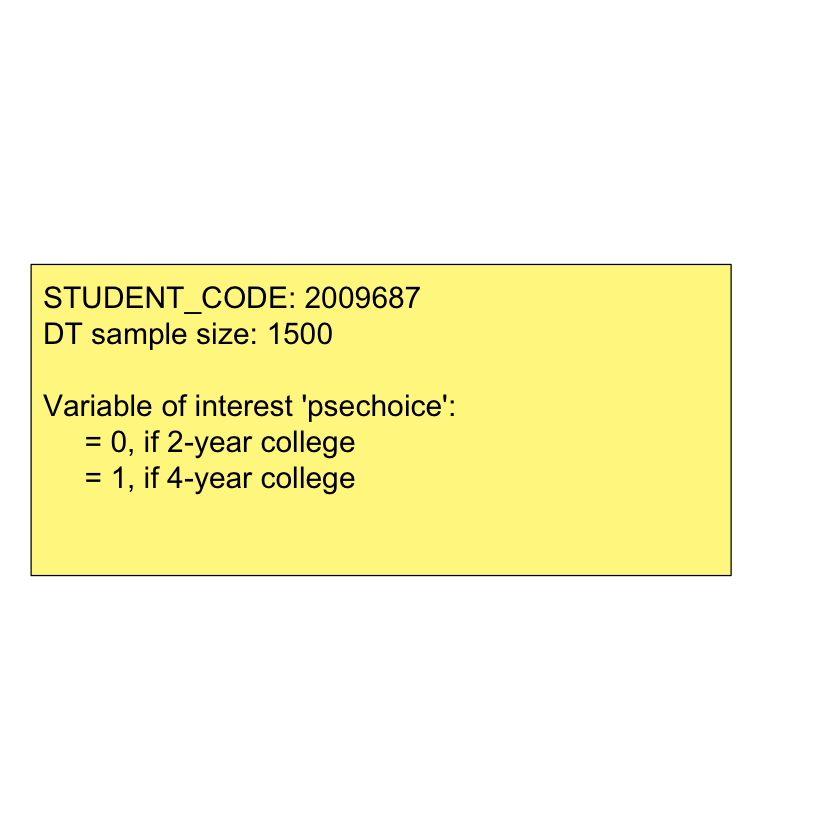

In [5]:
DT = get_data(STUDENT_CODE)

You should have a variable `DT` with the data.

In [73]:
head(DT)

,psechoice,hscath,hsrural,grades,faminc,famsiz,parsome,parcoll,female,asian,hispan,black,grants,loans
,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,9.95,42.5,2,1,0,0,0,0,1,0,0
2,0,0,0,4.67,22.5,3,1,0,1,0,1,0,0,0
3,1,1,0,5.79,62.5,2,0,1,0,0,0,0,1,0
4,1,0,0,6.86,42.5,5,1,0,1,0,0,1,0,0
5,1,0,1,5.11,22.5,6,0,0,1,0,1,0,0,0
6,0,0,0,5.39,62.5,5,0,1,1,1,0,0,0,0


In [74]:
nrow(DT)

[1] 1500

<div style="font-size: 20px; color: red;">
<b> Assume that we are tasked to determine a students' plans for further education after highschool, <code>psechoice</code>. </b>
</div>

To do this, carry out the following tasks:

# **TASK 1: Exploratory Data Analysis**
#### (a) Examine whether `asian`, `hispan` and `black` form the whole category of race in this dataset, or if there is a base indicator variable, which is not one of the three indicator variables for race?
#### (b) Split the dataset into a training dataset `DT_train`, which contains $80\%$ of the observations, and a testing dataset `DT_test`, which contains the remaining $20\%$ of the observations from the full dataset `DT`.
#### (c) Examine the data of `DT_train` - which independent variables relate to the dependent variable `psechoice` ? Are there any explanatory variables, which depend on each other?

Hint: after creating the training and testing datasets, examine `table(DT$psechoice)`, `table(DT_train$psechoice)` and `table(DT_test$psechoice)` and make sure that each dataset contains both `0` and `1` values for the loan default indicator variable.

First, let's check if asian, hispan and black form the whole category of race in this dataset:

In [125]:
min(DT[, "asian"] + DT[, "hispan"] + DT[, "black"])

[1] 0

Now, let's check all the other indicator variables:

In [126]:
min(DT[, "grants"] + DT[, "loans"])

[1] 0

In [127]:
min(DT[, "hscath"] + DT[, "hsrural"])

[1] 0

In [128]:
min(DT[, "parsome"] + DT[, "parcoll"])

[1] 0

None of the indicator variables sum to 1 - we can include all of the variables in our model without falling into a dummy variable trap (otherwise we would need to exclude one regional indicator variable from the model and treat it as a base region).

Now, let's split the data into Train and Test set:

In [129]:
dt_index   <- 1:nrow(DT)
smpl_index <- 1:floor(0.8 * length(dt_index))
dt5_train  <- DT[smpl_index, ]
dt5_test   <- DT[setdiff(dt_index, smpl_index), ]

Examine some variables to make sure all of them have both 0 and 1 in all datasets:

In [130]:
table(DT$psechoice)
table(dt5_train$psechoice)
table(dt5_test$psechoice)


   0    1 
 475 1025 


  0   1 
383 817 


  0   1 
 92 208 

In [131]:
table(DT$loans)
table(dt5_train$loans)
table(dt5_test$loans)


   0    1 
1133  367 


  0   1 
907 293 


  0   1 
226  74 

Now, we can analyse DT_train and look for relationships. Let's start with a boxplot, we will include indicator variables remembering that the 0 and 1 do not have any numerical interpretation.

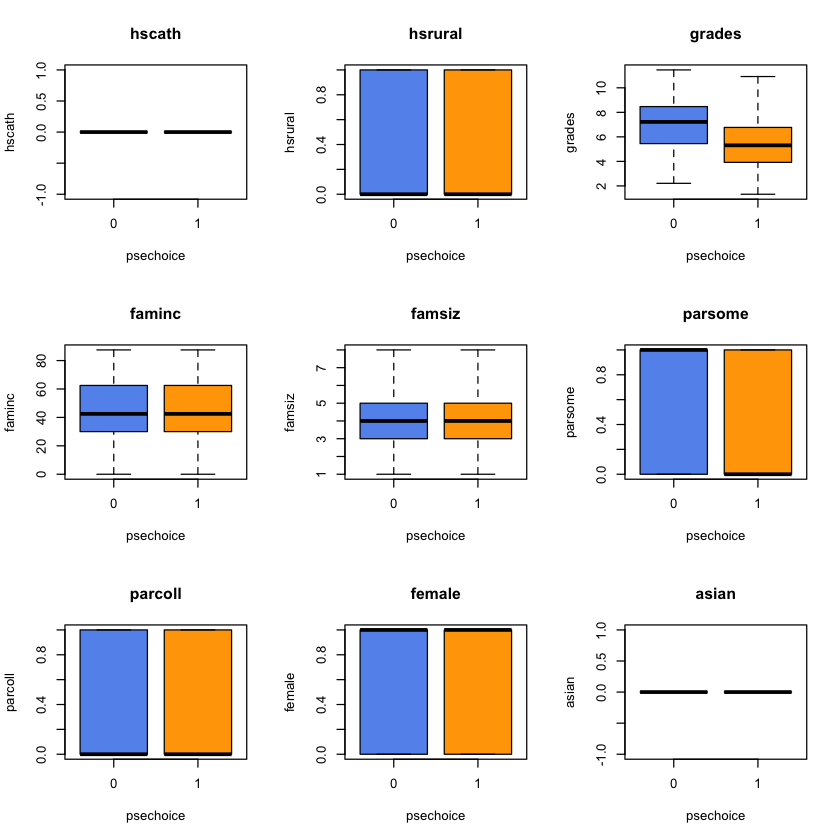

In [132]:
iter_cols = colnames(dt5_train)[1:14]
#
par(mfrow = c(3, 3),bg="white")
for(i in 2:10){
    tmp_formula <- formula(paste0(iter_cols[i],"~ psechoice"))
    boxplot(tmp_formula, dt5_train, 
            col = c("cornflowerblue", "orange"), 
            xlab = "psechoice", ylab = colnames(dt5_train)[i], outline = FALSE, 
            main = paste0(colnames(dt5_train)[i]))
}

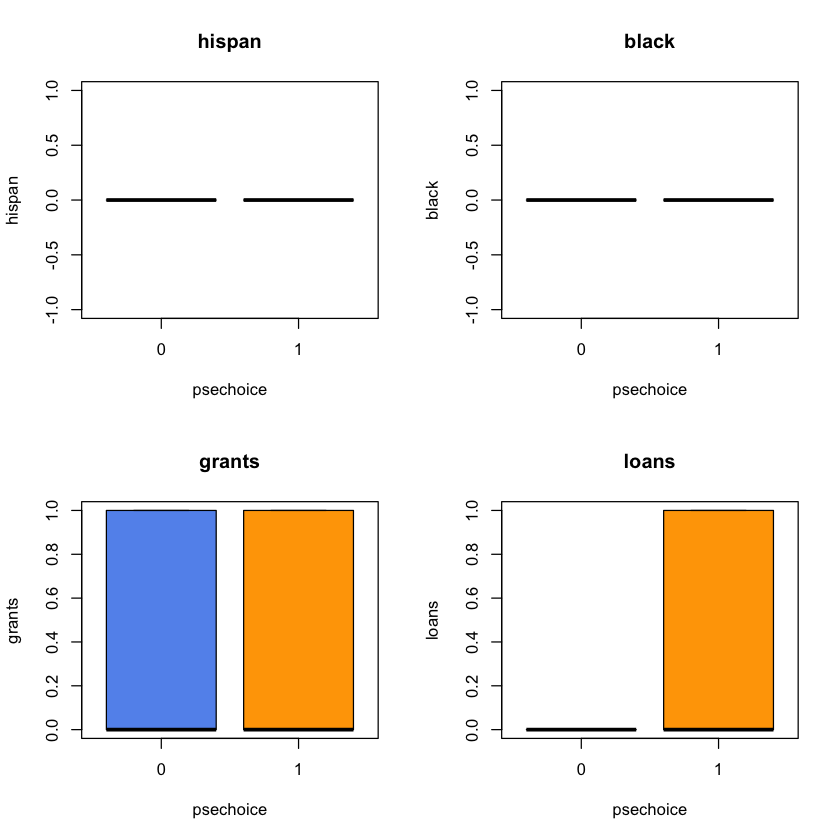

In [133]:
par(mfrow = c(2, 2),bg="white")
for(i in 11:14){
    tmp_formula <- formula(paste0(iter_cols[i]," ~ psechoice"))
    boxplot(tmp_formula, dt5_train, 
            col = c("cornflowerblue", "orange"), 
            xlab = "psechoice", ylab = colnames(dt5_train)[i], outline = FALSE, 
            main = paste0(colnames(dt5_train)[i]))
}

There seems to be a relationship between grades and psechoice: students with higher grades tend to choose 2 year degrees (psechoice=0).
There also seems to be a relationship between loans and pschoice. Since this latter is an indicator variable we will analyse it further using a contingency table:

In [134]:
tbl <- xtabs(~ loans + psechoice, data = dt5_train)
print(tbl)

     psechoice
loans   0   1
    0 358 549
    1  25 268


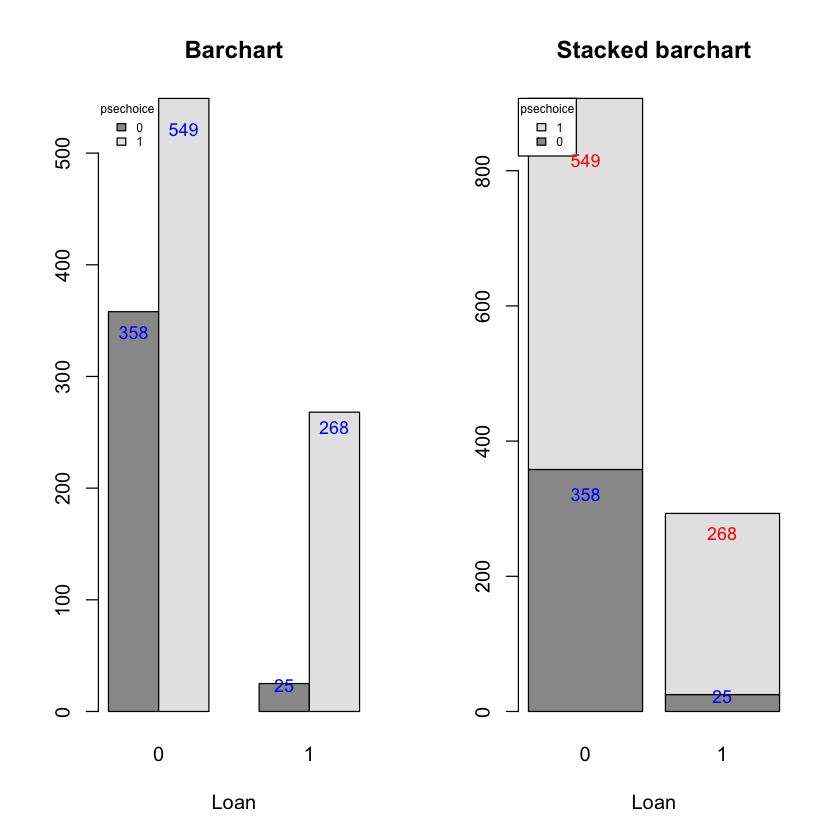

In [135]:
par(mfrow = c(1, 2),bg="white")
#
bb <- barplot(t(tbl), 
              beside = TRUE, col = c("grey60", "grey90"), main = "Barchart", 
              xlab = "Loan", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "n", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, c(t(tbl))*0.95, labels = c(t(tbl)), cex = 0.9, col = "blue")
#
#
#
bb <- barplot(t(tbl), 
              beside = FALSE, col = c("grey60", "grey90"), main = "Stacked barchart", 
              xlab = "Loan", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "y", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, t(tbl)[1,]*0.9, labels = t(tbl)[1,], cex = 0.9, col = "blue")
text(bb, colSums(t(tbl))*0.9, labels = t(tbl)[2,], cex = 0.9, col = "red")

There seems to be a relationship, most of those who choose a 4 year degree ask for a loan.

Let's check the female indicator variable as well:

In [136]:
tbl <- xtabs(~ female + psechoice, data = dt5_train)
print(tbl)

      psechoice
female   0   1
     0 182 377
     1 201 440


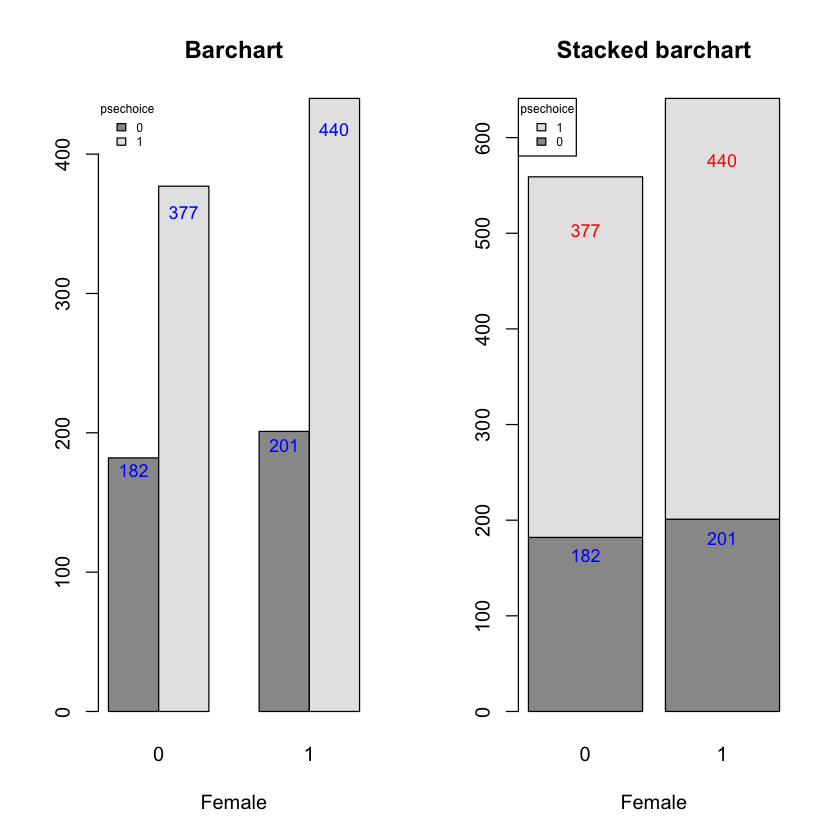

In [137]:
par(mfrow = c(1, 2),bg="white")
#
bb <- barplot(t(tbl), 
              beside = TRUE, col = c("grey60", "grey90"), main = "Barchart", 
              xlab = "Female", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "n", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, c(t(tbl))*0.95, labels = c(t(tbl)), cex = 0.9, col = "blue")
#
#
#
bb <- barplot(t(tbl), 
              beside = FALSE, col = c("grey60", "grey90"), main = "Stacked barchart", 
              xlab = "Female", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "y", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, t(tbl)[1,]*0.9, labels = t(tbl)[1,], cex = 0.9, col = "blue")
text(bb, colSums(t(tbl))*0.9, labels = t(tbl)[2,], cex = 0.9, col = "red")

There is no apparent relationship.

Let's check parcoll:

In [138]:
tbl <- xtabs(~ parcoll + psechoice, data = dt5_train)
print(tbl)

       psechoice
parcoll   0   1
      0 284 451
      1  99 366


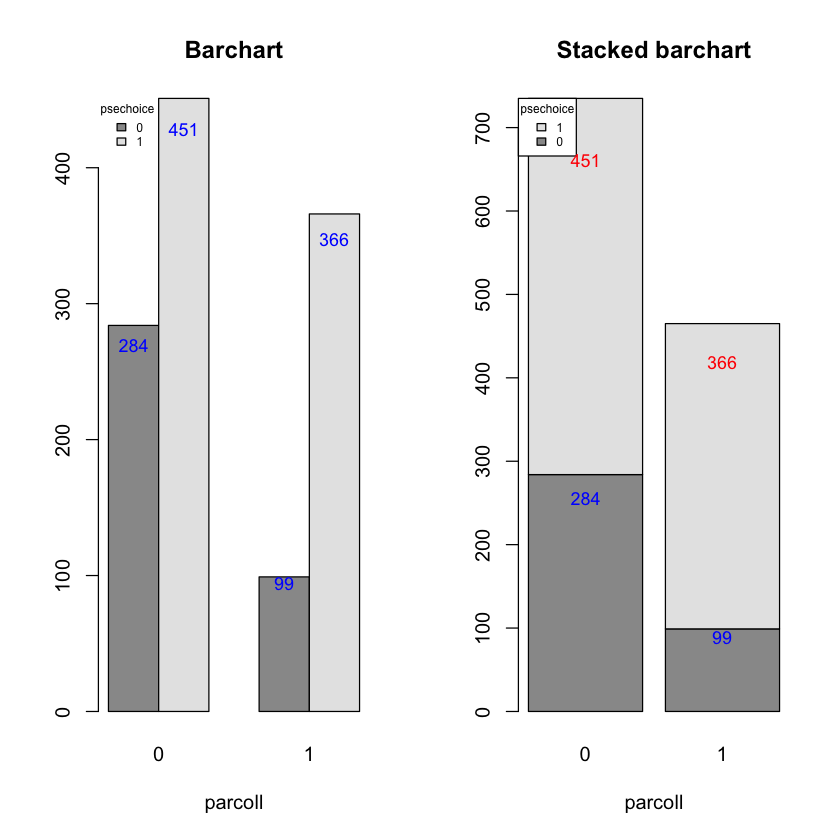

In [139]:
par(mfrow = c(1, 2),bg="white")
#
bb <- barplot(t(tbl), 
              beside = TRUE, col = c("grey60", "grey90"), main = "Barchart", 
              xlab = "parcoll", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "n", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, c(t(tbl))*0.95, labels = c(t(tbl)), cex = 0.9, col = "blue")
#
#
#
bb <- barplot(t(tbl), 
              beside = FALSE, col = c("grey60", "grey90"), main = "Stacked barchart", 
              xlab = "parcoll", legend.text = TRUE, 
              args.legend = list(x = "topleft", bty = "y", title = "psechoice", cex = 0.6))
# Add the numeric values to the bar chart
text(bb, t(tbl)[1,]*0.9, labels = t(tbl)[1,], cex = 0.9, col = "blue")
text(bb, colSums(t(tbl))*0.9, labels = t(tbl)[2,], cex = 0.9, col = "red")

It seems that students whose most educated parent has a college degree tend to prefer 4 year degrees.

Let's check for relationships between quantitive explanatory variables:

In [140]:
#From: https://stat.ethz.ch/R-manual/R-devel/library/graphics/html/pairs.html
panel.hist <- function(x, ...){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(usr[1:2], 0, 1.5) )
    h <- hist(x, plot = FALSE, breaks = 30)
    breaks <- h$breaks; nB <- length(breaks)
    y <- h$counts; y <- y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y, ...)
}
panel.abs_cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- abs(cor(x, y, use = "complete.obs"))
    txt <- format(c(r, 0.123456789), digits = digits)[1]
    txt <- paste0(prefix, txt)
    if(missing(cex.cor)) cex.cor <- 0.8/strwidth(txt)
    text(0.5, 0.5, txt, cex = 2)
}

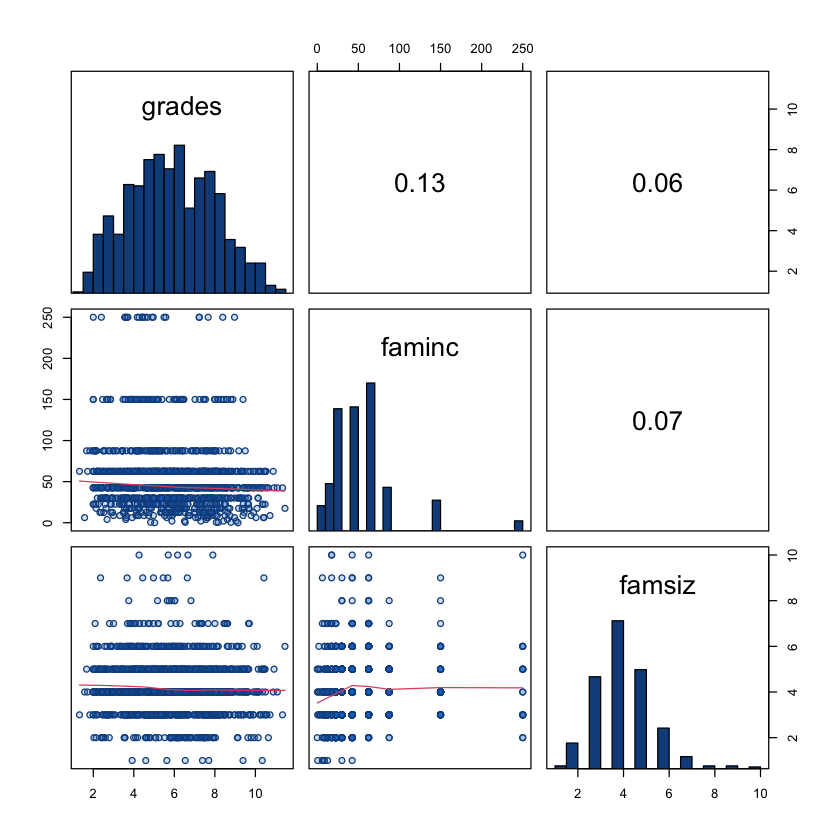

In [141]:
plt_cols <- c("grades", "faminc", "famsiz")
#
#
#
par(bg="white")
pairs(dt5_train[, plt_cols], 
      diag.panel = panel.hist, 
      lower.panel = panel.smooth, 
      upper.panel = panel.abs_cor, 
      col = "dodgerblue4", 
      pch = 21, 
      bg = adjustcolor("dodgerblue3", alpha = 0.2))

There is no apparent relationship.


<div style="font-size: 20px; color: red;">
<b> Use <code>DT_train</code> from TASK 1 to TASK 9. Only use <code>DT_test</code> on the last task, TASK 10! </b>
</div>

# **TASK 2: Variable Selection**
#### (a) Based on your answers in TASK 1, choose **at least two** continuous variables (i.e. non-categorical and non-indicator variables) - what signs do you expect them to take when modelling the probability that `psechoice = 1`? 
#### (b) Based on your answers in TASK 1, choose **at least two indicator AND/OR two categorical**  variables  - what signs do you expect them to take when modelling the probability that `psechoice = 1`?

Note: remember what the students' choice of `psechoice = 1` indicates in your data  sample.


<div style="font-size: 15px; color: red;">
<b> Do NOT include any interaction/polynomial variables in this task!</b>
</div>

Based on the above, we include in our model grades, faminc, loans and parcoll.

$\beta_{grades} < 0$ - Students with higher grades tend to invest more in their education. We expect a negative sign because the scale is inverted: 1 is the highest, larger value of grades represents poorer academic performance. Therefore, as the values of grades get larger (and the academic performance poorer) we expect the probability of choosing a 4 year degree to decrease.

$\beta_{faminc} > 0$ - Wealthy family have the means to support their sons at university for a longer period. Therefore, we expect students from wealthy families to prefer 4 year degrees.

$\beta_{loans} > 0$ - Those who stay in college longer need more money. If their parents cannot support them, they ask for a loan. Therefore, students who ask for a loan have ahigher probability to choose a 4 year degree.

$\beta_{parcoll} > 0$ - More educated parents tend to value education and may encourage their sons to choose a 4 year degree. Therefore, we expect students whose most educated parent has a college degree to be more inclined to choose a 4 year degree

# **TASK 3: Model Estimation**
#### (a) Estimate a `logit` regression model based on your selected variables from `TASK 2`. Are the variables significant? Are the signs as you expected? **If there are no significant independent variables (excluding the intercept), try to include other variables so that at least one is significant.**
#### (b) Estimate a `probit` regression model based on your selected variables from `TASK 2`. Are the variables significant? Are the signs as you expected? **If there are no significant independent variables (excluding the intercept), try to include other variables so that at least one is significant.**

<div style="font-size: 15px; color: red;">
<b> Do NOT include any interaction/polynomial variables in this task! Do not remove any insignificant variables!</b>
</div>

In [142]:
my_formula <- psechoice ~ 1 + grades + faminc + loans + parcoll 
logit_glm  <- glm(my_formula, data = dt5_train, family = binomial(link = "logit"))
print(round(coef(summary(logit_glm)), 5))

            Estimate Std. Error   z value Pr(>|z|)
(Intercept)  2.07253    0.26999   7.67626  0.00000
grades      -0.36750    0.03670 -10.01430  0.00000
faminc       0.00644    0.00210   3.07385  0.00211
loans        2.20856    0.23285   9.48492  0.00000
parcoll      0.67535    0.16051   4.20751  0.00003


In [143]:
probit_glm <- glm(my_formula, data = dt5_train, family = binomial(link = "probit"))
print(round(coef(summary(probit_glm)), 5))

            Estimate Std. Error   z value Pr(>|z|)
(Intercept)  1.22912    0.15667   7.84523  0.00000
grades      -0.21762    0.02110 -10.31444  0.00000
faminc       0.00387    0.00119   3.24352  0.00118
loans        1.25705    0.12307  10.21412  0.00000
parcoll      0.39283    0.09421   4.16975  0.00003


All the chosen variables are significant. Also, they sign are as expected.

# **TASK 4: Collinearity Testing**

#### (a) Check if there are any collinear variables.
#### (b) If you have found collinearities, remove the multicollinearity if it is meaningful to do so. Otherwise, indicate if there is no collinearity, or why there is no need to remove collinear variables (if you decide so).


In [144]:
print(cbind(car::vif(logit_glm)))

            [,1]
grades  1.011746
faminc  1.145947
loans   1.040473
parcoll 1.137615


In [145]:
print(cbind(car::vif(probit_glm)))

            [,1]
grades  1.017822
faminc  1.162575
loans   1.045929
parcoll 1.154722


The VIF is around 1, therefore there is no collinearity

# **TASK 5: Interaction and Polynomial variables**
#### (a) Select at least one interaction term **OR** at least one polynomial term - what signs do you expect them to take when modelling the probability that `psechoice = 1`?
#### (b) Estimate the `logit` and `probit` models with the additional variable(-s). Are the signs of the interaction/polynomial terms as you expected?
#### (c) Remove insignificant variables from you model, where it makes sense to do so (remember the relationship between the main effects and their interaction/polynomial effects and when it makes sense to remove insignificant terms in such cases. Also remember whether it is absolutely necessary to remove some insignificant indicator variables from a category, if there are some significant ones).

It may be interesting to check whether each additional 1000$ in gross income of the family still increases the probability of choosing a 4 year degree. We expect a positive sign.

In [146]:
my_formula_1 <- psechoice ~ 1 + grades + faminc + loans + parcoll +I(faminc^2)
logit_glm_1 <- glm(my_formula_1, data = dt5_train, family = binomial(link = "logit"))
print(round(coef(summary(logit_glm_1)), 5))

            Estimate Std. Error   z value Pr(>|z|)
(Intercept)  2.10763    0.30695   6.86631  0.00000
grades      -0.36764    0.03670 -10.01646  0.00000
faminc       0.00530    0.00521   1.01689  0.30921
loans        2.20356    0.23366   9.43045  0.00000
parcoll      0.68051    0.16200   4.20072  0.00003
I(faminc^2)  0.00001    0.00002   0.23997  0.81035


In [147]:
my_formula_1 <- psechoice ~ 1 + grades + faminc + loans + parcoll +I(faminc^2)
probit_glm_1 <- glm(my_formula_1, data = dt5_train, family = binomial(link = "probit"))
print(round(coef(summary(probit_glm_1)), 5))

            Estimate Std. Error   z value Pr(>|z|)
(Intercept)  1.24710    0.17900   6.96714  0.00000
grades      -0.21774    0.02110 -10.31757  0.00000
faminc       0.00330    0.00302   1.09019  0.27563
loans        1.25447    0.12360  10.14941  0.00000
parcoll      0.39581    0.09532   4.15259  0.00003
I(faminc^2)  0.00000    0.00001   0.20669  0.83625


In both models, the sign is positive but the polynomial variables is insignificant.

# **TASK 6: Model Equations**
#### Write down the fitted `logit` and `probit` model mathematical equations.

**Hint: Even if your model contains some insignificant categorical variable categories - as long as they are included in the model (i.e. as long as they are in the model `summary()`) - they need to be included in the equation.**


\begin{aligned}
\log \left( \dfrac{\widehat{p}_i}{1 - \widehat{p}_i} \right) &= \underset{(0.26999)}{2.07253} - \underset{(0.03670)}{0.36750} \cdot grades + \underset{(0.00210)}{0.00644} \cdot faminc + \underset{(0.23285)}{2.20856} \cdot loans \\
&+\underset{(0.16051)}{0.67535} \cdot parcoll
\end{aligned}

\begin{aligned}
\widehat{p}_i = \mathbf{\Phi} \bigg( \underset{(0.15667)}{1.22912} &-\underset{(0.02110)}{0.21762} \cdot grades + \underset{(0.00119)}{0.00387} \cdot faminc + \underset{(0.12307)}{1.25705} \cdot loans\\
&+ \underset{(0.09421)}{0.39283} \cdot parcoll
\end{aligned}

# **TASK 7: Examine the ROC curve**
#### (a) Examine the ROC curves of the models. Are they better than random guessing (i.e. are their curves greater than the diagonal line on the ROC curve)?
#### (b) Which model has the largest AUC?


In [148]:
ppred <- data.frame(logit = predict(logit_glm, dt5_train, type = "response"),
                    probit = predict(probit_glm, dt5_train, type = "response"))

Warning message:
“Removed 7 rows containing missing values (geom_text).”


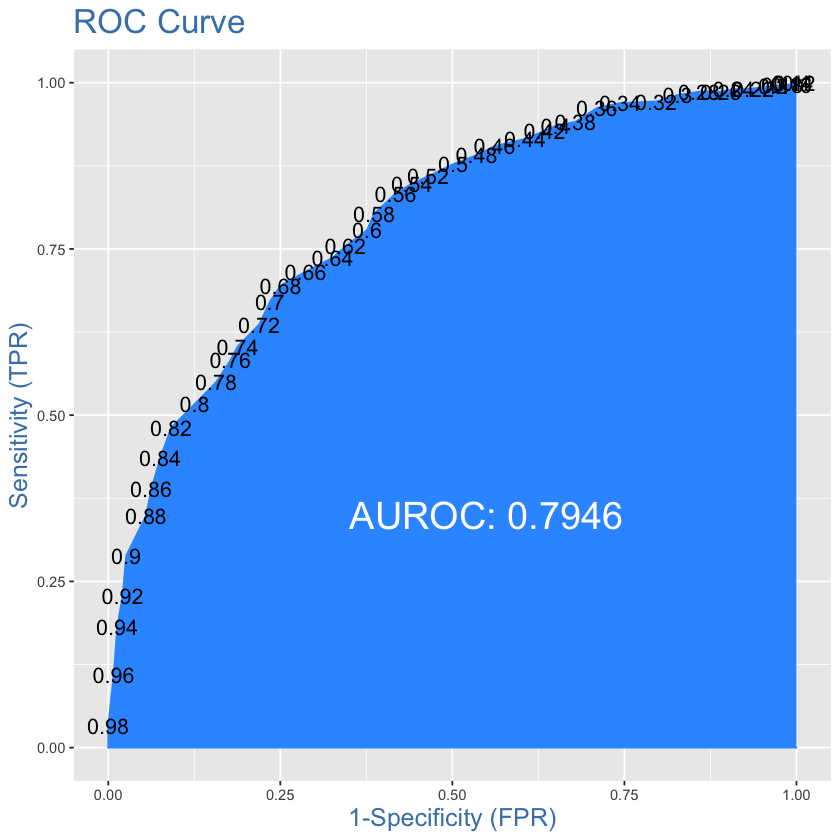

In [149]:
InformationValue::plotROC(dt5_train$psechoice, ppred$logit, Show.labels = TRUE)

Warning message:
“Removed 8 rows containing missing values (geom_text).”


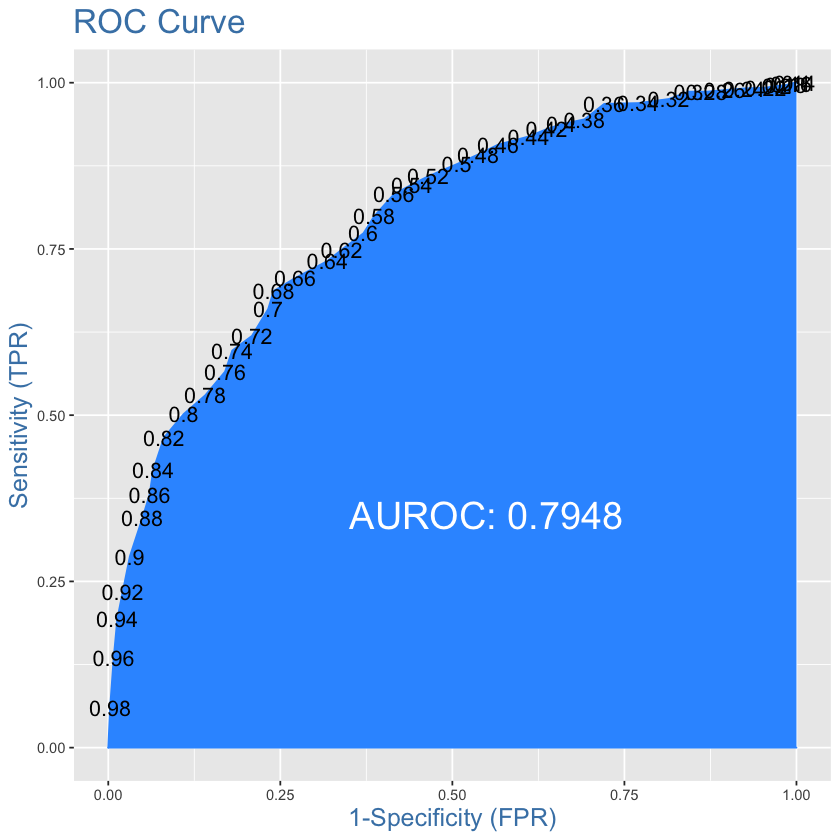

In [150]:
InformationValue::plotROC(dt5_train$psechoice, ppred$probit, Show.labels = TRUE)

Generally, an AUC of 0.7-08 indicates an adequate model; 0.5 indicates random guessing; 0.5-0.7 indicates a poor model. 
The AUC for both logit and probit models is very close to 0.8, indicating that our estimated models are adequate. The AUC is higher for the probit regression, although the difference is very small.

# **TASK 8: Confusion Matrix**
#### (a) Calculate the optimal cutoff prediction probabilities for the `logit` and `probit` models - are they the same value?
#### (b) Use the default (i.e. 0.5) cutoff prediction probability and calculate the confusion matrix for the `logit` and `probit` models.
#### (c) Use the optimal cutoff prediction probabilities and calculate the confusion matrix for the `logit` and `probit` models.
#### (d) **Assume that it is worse to predict a `0`, when in fact `psechoice = 1` - we want to be able to predict as many correct ACTUAL cases of `1`, as possible**. Compare the results - which cutoff value and for which model produces better results in terms of the Confusion Matrix?

In [151]:
predicted_probs_logit <- predict(logit_glm, dt5_train, type = "response")
optimalCutoff_logit <- InformationValue::optimalCutoff(dt5_train$psechoice, 
                                                       predicted_probs_logit, 
                                                       optimiseFor = "misclasserror")
print(optimalCutoff_logit)

[1] 0.5117179


In [152]:
predicted_probs_probit <- predict(probit_glm, dt5_train, type = "response")
optimalCutoff_probit <- InformationValue::optimalCutoff(dt5_train$psechoice, 
                                                       predicted_probs_probit, 
                                                       optimiseFor = "misclasserror")

print(optimalCutoff_probit)

[1] 0.5073018


The cutoff values for the logit and probit model are not the same.

In [153]:
tmp_out_logit <- InformationValue::confusionMatrix(dt5_train$psechoice, 
                                                 predicted_probs_logit, 
                                                 threshold = 0.5)
colnames(tmp_out_logit) <- paste0("Actual ", colnames(tmp_out_logit))
rownames(tmp_out_logit) <- paste0("Predicted ", rownames(tmp_out_logit))
print(tmp_out_logit)

            Actual 0 Actual 1
Predicted 0      191      100
Predicted 1      192      717


In [154]:
tmp_out_probit <- InformationValue::confusionMatrix(dt5_train$psechoice, 
                                                 predicted_probs_probit, 
                                                 threshold = 0.5)
colnames(tmp_out_probit) <- paste0("Actual ", colnames(tmp_out_probit))
rownames(tmp_out_probit) <- paste0("Predicted ", rownames(tmp_out_probit))
print(tmp_out_probit)

            Actual 0 Actual 1
Predicted 0      189      100
Predicted 1      194      717


In [155]:
tmp_out_logit_opt <- InformationValue::confusionMatrix(dt5_train$psechoice, 
                                                 predicted_probs_logit, 
                                                 threshold = optimalCutoff_logit)
colnames(tmp_out_logit_opt) <- paste0("Actual ", colnames(tmp_out_logit_opt))
rownames(tmp_out_logit_opt) <- paste0("Predicted ", rownames(tmp_out_logit_opt))
print(tmp_out_logit_opt)

            Actual 0 Actual 1
Predicted 0      200      109
Predicted 1      183      708


In [156]:
tmp_out_probit_opt <- InformationValue::confusionMatrix(dt5_train$psechoice, 
                                                 predicted_probs_probit, 
                                                 threshold = optimalCutoff_probit)
colnames(tmp_out_probit_opt) <- paste0("Actual ", colnames(tmp_out_probit_opt))
rownames(tmp_out_probit_opt) <- paste0("Predicted ", rownames(tmp_out_probit_opt))
print(tmp_out_probit_opt)

            Actual 0 Actual 1
Predicted 0      197      104
Predicted 1      186      713


Now, let's compare the models assuming that we want to be able to predict as many correct actual 1 as possible.

In [157]:
print((tmp_out_logit['Predicted 1', 'Actual 1'] / tmp_out_logit_opt['Predicted 1', 'Actual 1'] - 1) * 100)

[1] 1.271186


In the logit model, we have correctly classified 1.271186% more actual 1  with the standard cutoff (0.5). Given our assumption, the standard cutoff is better.

In [158]:
print((tmp_out_probit['Predicted 1', 'Actual 1'] / tmp_out_probit_opt['Predicted 1', 'Actual 1'] - 1) * 100)

[1] 0.5610098


For our purposes, the standard cutoff seems to work better for the probit model as well.

Now, we will compare the logit and probit model with the standard cutoff.

In [159]:
print((tmp_out_probit['Predicted 1', 'Actual 1'] / tmp_out_logit['Predicted 1', 'Actual 1'] - 1) * 100)

[1] 0


There is no difference between the logit and probit models with standard cutoff. By looking at the confusion matrices we see that both predict 717 actual 1.

# **TASK 9: Variable Interpretation**
#### (a) Select one model, which you believe is the best, from the results in `TASK 7` and `TASK 8` and give your reasoning.
#### (b) For the **best** selected model, calculate its PEA (Partial effects at the average) and APE (Average partial effects) and **interpret** the results.

As far as prediction of actual 1 is concerned, the models perform excatly the same. The ROC is very similar as well, but the probit performace is slightly superior. Therefore, we will choose the probit model and calculate the PEA and APE for this model.

In [160]:
PEA_probit = mfx::probitmfx(formula = probit_glm$formula, data = probit_glm$data, atmean = TRUE)
print(PEA_probit$mfxest)

               dF/dx    Std. Err.          z        P>|z|
grades  -0.071884892 0.0069155551 -10.394667 2.622012e-25
faminc   0.001278313 0.0003932912   3.250295 1.152853e-03
loans    0.320388819 0.0217456034  14.733499 3.928304e-49
parcoll  0.125700994 0.0289928283   4.335589 1.453702e-05


A unit increase in the sample average value of grades results in a 0.07188 decrease (-0.07188) in the probability of choosing a 4 year degree.

A unit increase in the sample average value of faminc results in a 0.00127 increase in the probability of choosing a 4 year degree.

Students who received a loan while attending college have 0.32038 more probabilities of choosing a 4 year degree

Students whose most educated parent has a college degree have 0.12570 more probabilities of choosing a 4 year degree

As far as indicator variables are concerned, the PEA has some problems: the average of an indicator represents the fraction of the sample that has the characteristic measured by the indicator value. For example, the average of the loans indicator represents only the part of the sample that took the loan (loans=1).

In [161]:
APE_probit = mfx::probitmfx(formula = probit_glm$formula, data = probit_glm$data, atmean = FALSE)
print(APE_probit$mfxest)

              dF/dx    Std. Err.          z        P>|z|
grades  -0.06149044 0.0051380172 -11.967738 5.243880e-33
faminc   0.00109347 0.0003330679   3.283025 1.026994e-03
loans    0.30820467 0.0219512737  14.040400 8.821315e-45
parcoll  0.11148018 0.0263640939   4.228485 2.352702e-05


A unit increase in grades results in the sample average estimated decrease of 0.06149 (-0.06149) in the probability of choosing a 4 year degree.

A unit increase in faminc results in the sample average estimated increase of 0.00109 in the probability of choosing a 4 year degree.

Students who received a loan while attending college have 0.30820 more probabilities of choosing a 4 year degree

Students whose most educated parent has a college degree have 0.11148 more probabilities of choosing a 4 year degree

# **TASK 10: Out-of-sample Validation**
#### (a) Calculate the fitted values for the `testing` dataset, `DT_test`, which was not used when estimating the model parameters.
#### (b) Using the selected model from `TASK 9` and its cutoff value from `TASK 8 (d)`, and calculate the Confusion Matrix.
#### (c) Examine the results - are they similar to the ones you got on your `training` dataset (i.e. `TASK 8` results) in terms of True Positive, True Negative, False Negative and False Positive? Would you say your model is robust (i.e. it works adequately well for new data)?

In [162]:
probs_probit_test <- predict(probit_glm, 
                             newdata = dt5_test, type = "response")

In [163]:
test <- InformationValue::confusionMatrix(dt5_test$psechoice, probs_probit_test, threshold = 0.5)
colnames(test) <- paste0("Actual ", colnames(test))
rownames(test) <- paste0("Predicted ", rownames(test))
print(test)

            Actual 0 Actual 1
Predicted 0       48       37
Predicted 1       44      171


Let's compare the results to the result fromthe training data.

Since we assume that we want to predict as many actual 1 as possible, the precision of the TPR is particularly important:

In [164]:
print(InformationValue::sensitivity(dt5_train$psechoice, 
                                    predicted_probs_probit, 
                                    threshold = 0.5))

[1] 0.877601


In [165]:
print(InformationValue::sensitivity(dt5_test$psechoice, 
                                    probs_probit_test, 
                                    threshold = 0.5))

[1] 0.8221154


The sensitivity decreases, but 0.82 seems like an acceptable result. The model is adequate for our specific goal.

We will also check Precision, True Negative, False Negative and False Positive.

Precision:

In [166]:
print(InformationValue::precision(dt5_train$psechoice,
                                  predicted_probs_probit, 
                                  threshold = 0.5))

[1] 0.7870472


In [167]:
print(InformationValue::precision(dt5_test$psechoice, probs_probit_test, 
                                  threshold = 0.5))

[1] 0.7953488


The precision increases with the test data.

True Negative:

In [168]:
print(InformationValue::specificity(dt5_train$psechoice, predicted_probs_probit,
                                    threshold = 0.5))

[1] 0.4934726


In [169]:
print(InformationValue::specificity(dt5_test$psechoice, probs_probit_test,
                                    threshold = 0.5))

[1] 0.5217391


The specificity increases with the test data. 

The specificity is not very high, but given our (assumed) goals sensitivity is more important.

False Positive:

In [170]:
print(1 - InformationValue::specificity(dt5_train$psechoice, 
                                        predicted_probs_probit, 
                                        threshold = 0.5))

[1] 0.5065274


In [171]:
print(1 - InformationValue::specificity(dt5_test$psechoice, 
                                        probs_probit_test, 
                                        threshold = 0.5))

[1] 0.4782609


The FPR decreases slightly, which is good.

False Negative:

In [172]:
print(1 - InformationValue::sensitivity(dt5_train$psechoice, 
                                        predicted_probs_probit,
                                        threshold = 0.5))

[1] 0.122399


In [173]:
print(1 - InformationValue::sensitivity(dt5_test$psechoice, 
                                        probs_probit_test,
                                        threshold = 0.5))

[1] 0.1778846


The FNR increases slightly.

On the whole, the model seems robust. Also, it seems to do a good job in identifiying as many actual 1 as possible, which is our goal.